In [43]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
import os
import astropy.io.fits as fits
from astropy.table import Table, Column
from desitarget import desi_mask, bgs_mask, mws_mask, contam_mask, obsmask
from desiutil.plots import prepare_data, init_sky, plot_sky_circles, plot_sky_binned
from desiutil.log import get_logger
import warnings
import mpl_toolkits
%matplotlib inline

In [2]:
import desisurvey
import desisurvey.ephemerides

In [7]:
topdir = os.path.join("/global/cscratch1/sd/forero/quicksurvey2017b/")

In [8]:
ls $topdir

commands.sh*   fiberassign/      survey/   zcat/
commands.sh~*  fiberassign.log*  targets/


# MWS Results

In [ ]:
!ls -lhtr $topdir/zcat/bright/34/zcat.fits

In [11]:
zcat_path = '{topdir}/zcat/bright/34/zcat.fits'.format(topdir=topdir)
zcat = Table.read(zcat_path)

In [12]:
print((zcat['SPECTYPE'] == 'GALAXY').sum())
print((zcat['SPECTYPE'] == 'STAR').sum())
len(zcat)

17095205
10668205


27763410

In [13]:
zcat[0:3]

TARGETID,BRICKNAME,SPECTYPE,Z,ZERR,ZWARN,NUMOBS
int64,str8,str10,float32,float32,int32,int32
288230376151711750,,GALAXY,0.248714,5.41471e-05,0,3
288230376151711759,,GALAXY,0.235782,5.35852e-05,0,1
288230376151711760,,GALAXY,0.220773,5.29372e-05,0,1


# Survey Schedule

In [14]:
ls $topdir/survey

config.yaml*                       plan_2024-09-05.fits*
ephem_2019-12-01_2024-11-30.fits*  progress.fits*
exposures.fits*                    progress_2020-05-12.fits*
exposures_bright.fits*             progress_2020-05-20.fits*
exposures_dark.fits*               progress_2020-05-29.fits*
fiberassign_dates_bright.txt*      progress_2020-06-27.fits*
fiberassign_dates_dark.txt*        progress_2020-10-16.fits*
last_date.txt*                     progress_2020-11-06.fits*
plan.fits*                         progress_2021-03-04.fits*
plan_2020-05-12.fits*              progress_2021-04-01.fits*
plan_2020-05-20.fits*              progress_2021-05-01.fits*
plan_2020-05-29.fits*              progress_2021-05-13.fits*
plan_2020-06-27.fits*              progress_2021-05-16.fits*
plan_2020-10-16.fits*              progress_2021-11-07.fits*
plan_2020-11-06.fits*              progress_2022-01-14.fits*
plan_2021-03-04.fits*              progress_2022-01-27.fits*
plan_2021-04-01.fits*              prog

There are 35 epochs in this survey: one of 6 months at the start, then (almost) every month thereafter.

In [15]:
!wc -l $topdir/survey/fiberassign_dates_bright.txt
!cat $topdir/survey/fiberassign_dates_bright.txt

35 /global/cscratch1/sd/forero/quicksurvey2017b//survey/fiberassign_dates_bright.txt
2019-12-01
2020-06-05
2020-07-04
2020-08-02
2020-10-01
2020-10-30
2020-11-29
2020-12-29
2021-01-27
2021-03-27
2021-04-26
2021-05-25
2021-06-23
2021-07-23
2021-09-20
2021-10-19
2021-11-18
2021-12-18
2022-01-17
2022-03-17
2022-04-15
2022-05-15
2022-06-13
2022-07-12
2022-09-09
2022-10-09
2022-11-07
2022-12-07
2023-01-06
2023-03-06
2023-04-05
2023-05-04
2023-06-03
2023-07-02
2023-07-31


In [16]:
our_ephem = Table.read("{topdir}/survey/ephem_2019-12-01_2024-11-30.fits".format(topdir=topdir))
weather   = Table.read("{topdir}/survey/weather_123.fits".format(topdir=topdir))
plan      = Table.read("{topdir}/survey/plan.fits".format(topdir=topdir))
exposures = Table.read("{topdir}/survey/exposures_bright.fits".format(topdir=topdir))
stats     = Table.read("{topdir}/survey/stats.fits".format(topdir=topdir))

## Twilight time

In [18]:
len(np.unique(exposures['night']))

597

In [19]:
our_ephem[0:2]

noon,dusk,dawn,brightdusk,brightdawn,moonrise,moonset,moon_illum_frac,brightstart,brightstop,moon_ra [25],moon_dec [25],mars_ra [25],mars_dec [25],jupiter_ra [25],jupiter_dec [25],venus_ra [25],venus_dec [25],uranus_ra [25],uranus_dec [25],saturn_ra [25],saturn_dec [25],neptune_ra [25],neptune_dec [25]
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
58818.7916667,58819.0648814,58819.5402392,58819.0580229,58819.5471045,58818.7738772,58819.2214304,0.315489669913,58819.2916667,58819.2916667,315.855105756 .. 328.313405912,-20.5423307847 .. -17.539536838,216.065378304 .. 216.708564259,-13.6575110791 .. -13.8767281034,269.764817088 .. 270.006987866,-23.2989208847 .. -23.3008047723,277.879049509 .. 279.241556201,-24.7291091375 .. -24.6841840177,31.2658515215 .. 31.236328578,12.1393935297 .. 12.1293820506,289.554894854 .. 289.663373708,-22.1289755824 .. -22.1167690065,347.457148572 .. 347.459515781,-6.50614868175 .. -6.50467317316
58819.7916667,58820.0649029,58820.5407486,58820.0580377,58820.5476203,58819.8006318,58820.2601936,0.407848006491,58820.2916667,58820.2916667,328.313405912 .. 340.121507654,-17.539536838 .. -13.8899876705,216.708564259 .. 217.353268758,-13.8767281034 .. -14.0943427305,270.006987866 .. 270.249789827,-23.3008047723 .. -23.3023052641,279.241556201 .. 280.602584172,-24.6841840177 .. -24.6267600112,31.236328578 .. 31.2073609524,12.1293820506 .. 12.1195694614,289.663373708 .. 289.772672548,-22.1167690065 .. -22.1043796725,347.459515781 .. 347.462410248,-6.50467317316 .. -6.5029759855


In [119]:
# This illustrates the logic used in the follow cell

inoon     = our_ephem['noon'].searchsorted(exposures['mjd'],side='left')
ibdusk    = our_ephem['brightdusk'].searchsorted(exposures['mjd'],side='left')
idusk     = our_ephem['dusk'].searchsorted(exposures['mjd'],side='left')
idawn     = our_ephem['dawn'].searchsorted(exposures['mjd'],side='left')
ibdawn    = our_ephem['brightdawn'].searchsorted(exposures['mjd'],side='left')
ibtstart  = our_ephem['brightstart'].searchsorted(exposures['mjd'],side='left')
ibtstop   = our_ephem['brightstop'].searchsorted(exposures['mjd'],side='left')

slc = slice(10,30)
print(' N',inoon[slc])
print('BT',ibdusk[slc])
print(' T',idusk[slc])
print('B0',ibtstart[slc])
print('B1',ibtstop[slc])
print(' D',idawn[slc])
print('BD',ibdawn[slc])

 N [4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
BT [4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
 T [4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
B0 [3 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
B1 [3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
 D [3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]
BD [3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [462]:
def report_bright_exposures(exposures,our_ephem):
    """
    Bright dusk/dawn: -13
    Dusk/dawn: -15
    """
    inoon     = our_ephem['noon'].searchsorted(exposures['mjd'],side='left')
    ibdusk    = our_ephem['brightdusk'].searchsorted(exposures['mjd'],side='left')
    idark0    = our_ephem['dusk'].searchsorted(exposures['mjd'],side='left')
    idark1    = our_ephem['dawn'].searchsorted(exposures['mjd'],side='left')
    ibdawn    = our_ephem['brightdawn'].searchsorted(exposures['mjd'],side='left')
    ibtstart  = our_ephem['brightstart'].searchsorted(exposures['mjd'],side='left')
    ibtstop   = our_ephem['brightstop'].searchsorted(exposures['mjd'],side='left')

    is_btp              = (ibtstart == inoon) & (ibtstart > ibtstop)

    # dark0 and dark1 are the periods of dark time before and after the moon is up,
    # or just the first and second half of the night if there is no moon.
    
    is_bright_dusk      = (ibdusk   == inoon) & (ibdusk   > idark0)
    is_dark0            = (idark0   == inoon) & (ibdusk  == idark0) & ~is_btp
    is_dark1            = (idark1   == inoon) & (ibdawn   < idark1) & ~is_btp
    is_bright_dawn      = (ibdawn   == inoon) & (ibdawn  == idark1)
    
    # brightstart and brightstop have to be between sunset and sunrise (as defined for
    # the dark time). They correspond to the period over which bright (moon) conditions
    # prevail on an otherwise dark night. If there is no such time, both are set to
    # midnight (i.e. there is zero time for the BTP on that night)
    is_btp_dark1            = (idark1    == inoon) & (ibdusk  == idark0) & is_btp
    is_btp_dark0            = (idark0    == inoon) & (ibdawn   < idark1) & is_btp
    
    # Grey definition:
    # max_moon_illumination: 0.6
    # max_moon_illumination_altitude_product: 30 deg

    print('Total exposure time (hrs): %-5.2f'%(exposures['exptime'].sum()/3600.0))
    print()
    print('Dusk:            %-5.2f'%(exposures['exptime'][is_bright_dusk].sum()/3600.0))
    print('Dark Night 0:    %-5.2f'%(exposures['exptime'][is_dark0].sum()/3600.0))
    print('Bright Night:    %-5.2f'%(exposures['exptime'][is_btp].sum()/3600.0))
    print('Dark Night 1:    %-5.2f'%(exposures['exptime'][is_dark1].sum()/3600.0))
    print('Dawn:            %-5.2f'%(exposures['exptime'][is_bright_dawn].sum()/3600.0))
    
    total_hours = exposures['exptime'][is_bright_dusk | is_dark0 | is_btp | is_dark1 | is_bright_dawn].sum()/3600.0
    print('Sum:             %-5.2f'%(total_hours))
    print()

    btp_hours      = exposures['exptime'][is_btp].sum()/3600.0
    twilight_hours = exposures['exptime'][(is_bright_dusk | is_bright_dawn)].sum()/3600.0
    dark_hours     = exposures['exptime'][(is_dark0 | is_dark1)].sum()/3600.0

    # The BTP is time that would be dark if it weren't for the Moon.
    print('Fractions of total time :')
    print('Twilight: %f'%(twilight_hours/total_hours))
    print('Bright:   %f'%(btp_hours/total_hours))
    print('Dark:     %f'%(dark_hours/total_hours))
    
    return

In [463]:
exposures_bright = Table.read("{topdir}/survey/exposures_bright.fits".format(topdir=topdir))
report_bright_exposures(exposures_bright,our_ephem)

Total exposure time (hrs): 1141.42

Dusk:            85.57
Dark Night 0:    362.95
Bright Night:    692.90
Dark Night 1:    11.31
Dawn:            0.00 
Sum:             1141.42

Fractions of total time :
Twilight: 0.074969
Bright:   0.607049
Dark:     0.317982


In [464]:
exposures_dark = Table.read("{topdir}/survey/exposures_dark.fits".format(topdir=topdir))
report_bright_exposures(exposures_dark,our_ephem);

Total exposure time (hrs): 4733.21

Dusk:            0.00 
Dark Night 0:    4729.32
Bright Night:    3.89 
Dark Night 1:    0.00 
Dawn:            0.00 
Sum:             4733.21

Fractions of total time :
Twilight: 0.000000
Bright:   0.000823
Dark:     0.999177


In [465]:
exposures_all = Table.read("{topdir}/survey/exposures.fits".format(topdir=topdir))
report_bright_exposures(exposures_all,our_ephem)

Total exposure time (hrs): 5874.63

Dusk:            85.57
Dark Night 0:    5092.27
Bright Night:    696.79
Dark Night 1:    11.31
Dawn:            0.00 
Sum:             5874.63

Fractions of total time :
Twilight: 0.014566
Bright:   0.118610
Dark:     0.866823


In [466]:
def plot_exposures(i_day_start,n_days):
    
    plt.figure(figsize=(16,3))

    seconds = 1.0/(24*60*60)

    SMIN, SMAX = 0,1
    PMIN, PMAX = SMAX,SMAX+1
    MMIN, MMAX = PMAX,PMAX+1
    BMIN, BMAX = MMAX,MMAX+1
    DMIN, DMAX = BMAX,BMAX+1
    WMIN, WMAX = DMAX,DMAX+1
    
    daystart = our_ephem[i_day_start]['noon']
    dayend   = our_ephem[i_day_start]['noon']+n_days
    
    ibright = exposures_bright['mjd'].searchsorted(daystart,side='left')
    jbright = exposures_bright['mjd'].searchsorted(dayend,side='left')
    print(jbright-ibright,'bright exp')
    for i in range(ibright,jbright+1):
        plt.fill_betweenx([BMIN,BMAX],
                              exposures_bright['mjd'][i],
                              exposures_bright['mjd'][i]+seconds*exposures_bright['exptime'][i],
                              edgecolor='None',
                              color='purple',alpha=1)
            
    idark = exposures_dark['mjd'].searchsorted(daystart,side='left')
    jdark = exposures_dark['mjd'].searchsorted(dayend,side='left')  
    print(jdark-idark,'dark exp')
    for i in range(idark,jdark+1):
        plt.fill_betweenx([DMIN,DMAX],
                          exposures_dark['mjd'][i],
                          exposures_dark['mjd'][i]+seconds*exposures_dark['exptime'][i],
                          edgecolor='None',
                          color='grey',alpha=1)

    iall = exposures_all['mjd'].searchsorted(daystart,side='left')
    jall = exposures_all['mjd'].searchsorted(dayend,side='left')  
    print(jall-iall,'total exp')        
    for i in range(iall,jall+1):
        plt.fill_betweenx([WMIN,WMAX],
                          exposures_all['mjd'][i],
                          exposures_all['mjd'][i]+seconds*exposures_all['exptime'][i],
                          edgecolor='None',
                          color='gold',alpha=0.1)
        
        if (exposures_all['transparency'][i] < 0.7):
            plt.fill_betweenx([WMIN,WMAX],
                          exposures_all['mjd'][i],
                          exposures_all['mjd'][i]+seconds*exposures_all['exptime'][i],
                          edgecolor='None',
                          color='lime',alpha=0.5)
            
        if (exposures_all['seeing'][i] > 1.5):
            plt.fill_betweenx([WMIN,WMAX],
                          exposures_all['mjd'][i],
                          exposures_all['mjd'][i]+seconds*exposures_all['exptime'][i],
                          edgecolor='None',
                          color='brown',alpha=1)
        #else:
        #     print(i,exposures['mjd'][i],dayend)

    #for i in range(0,100):
    #    plt.axvline(exposures_dark['mjd'][i],c='pink',alpha=0.5,zorder=-10)

    plt.xlim(daystart,dayend)
    plt.ylim(0,WMAX+0.5)

    for j in range(0,100):
        i = i_day_start + j
        if our_ephem['noon'][i] <= dayend:

            plt.fill_betweenx([SMIN,SMAX],
                              our_ephem['brightdusk'][i],
                              our_ephem['dusk'][i],
                              edgecolor='None',
                              color='red',alpha=0.5)

            plt.fill_betweenx([SMIN,SMAX],
                              our_ephem['dusk'][i],
                              our_ephem['brightstart'][i],
                              edgecolor='None',
                              color='y',alpha=0.5)

            if our_ephem['brightstart'][i] != our_ephem['brightstop'][i]:
                plt.fill_betweenx([PMIN,PMAX],
                              our_ephem['brightstart'][i],
                              our_ephem['brightstop'][i],
                              edgecolor='None',
                              color='orange',alpha=1)
            else:
                plt.axvline(our_ephem['brightstart'][i],c='pink',
                            ls='solid',lw=0.5,zorder=-10)

            plt.fill_betweenx([SMIN,SMAX],
                              our_ephem['brightstop'][i],
                              our_ephem['dawn'][i],
                              edgecolor='None',
                              color='c',alpha=0.5)

            plt.fill_betweenx([SMIN,SMAX],
                              our_ephem['dawn'][i],
                              our_ephem['brightdawn'][i],
                              color='b',alpha=0.5)

            plt.fill_betweenx([MMIN,MMAX],
                              our_ephem['moonrise'][i],
                              our_ephem['moonset'][i],
                              edgecolor='None',
                              color='g',alpha=0.5)
            
            plt.axvline(our_ephem['brightdusk'][i],c='lightgrey',
                            ls='--',zorder=-10,lw=0.5)
            
            plt.axvline(our_ephem['brightdawn'][i],c='lightgrey',
                            ls='--',zorder=-10,lw=0.5)

    ax = plt.gca()
    for (_min, _max, label) in [(SMIN,SMAX,'Dusk/Dawn'),
                                (PMIN,PMAX,'Bright Time Program'),
                                (MMIN,MMAX,'Moon up'),
                                (BMIN,BMAX,'Bright Time Obs'),
                                (DMIN,DMAX,'Dark/Grey Time Obs'),
                                (WMIN,WMAX,'Weather'),
                               ]:
        y = _min + 0.45*(_max-_min)
        plt.text(daystart+0.01,y,label,
                 bbox=dict(facecolor='w', edgecolor='none',alpha=0.5))

4 bright exp
41 dark exp
45 total exp


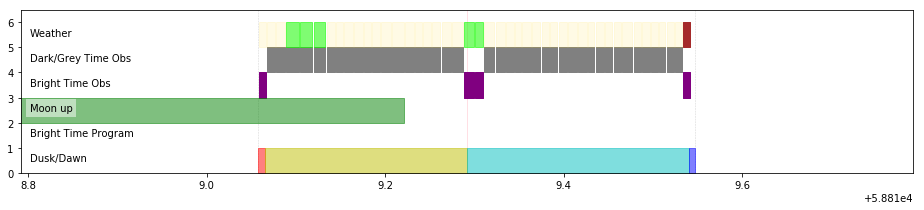

In [445]:
plot_exposures(0,1)

10 bright exp
33 dark exp
43 total exp


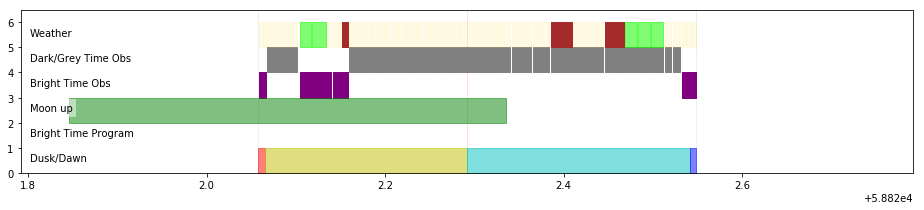

In [446]:
plot_exposures(3,1)

75 bright exp
66 dark exp
141 total exp


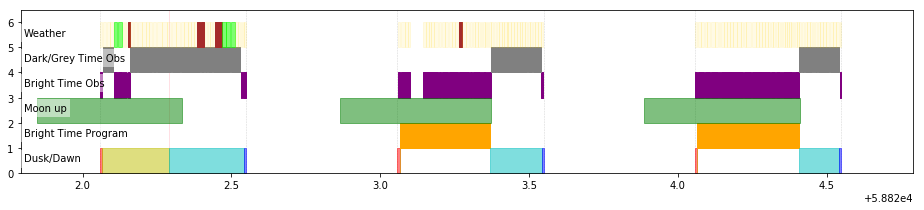

In [447]:
plot_exposures(3,3)

82 bright exp
23 dark exp
105 total exp


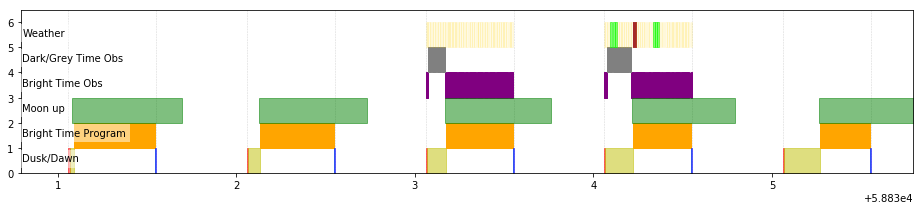

In [452]:
plot_exposures(12,5)

437 bright exp
1126 dark exp
1563 total exp


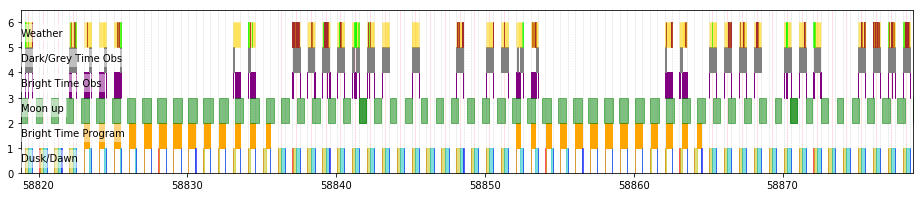

In [451]:
plot_exposures(0,60)

Numbers in documents are 450-500 hours/year

In [467]:
450*5

2250

In [77]:
450*5

2250

In [103]:
tiles = Table.read('{topdir}/targets/dark/all_tiles.fits'.format(topdir=topdir))

In [106]:
tiles[0:3]

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
4,335.03,19.88,0,1,0.0515615,1.05189,3973.28,1.45784,DARK,1
6,333.22,14.84,0,1,0.0612336,1.07788,3629.73,1.59411,DARK,1
7,332.35,12.32,0,1,0.0744952,1.0946,3596.16,1.76162,DARK,1


In [108]:
tiles[np.flatnonzero(tiles['TILEID'] == 26417)]

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
26417,96.95,52.24,4,1,0.12174,1.08659,5954.76,2.32685,GRAY,2


## Weather

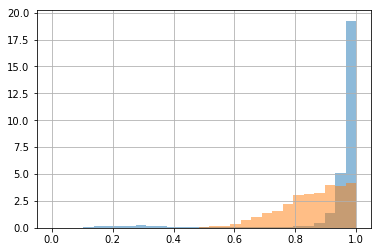

In [25]:
plt.hist(exposures['transparency'],bins=np.linspace(0,1,30),alpha=0.5,normed=True);
plt.hist(exposures['seeing'],bins=np.linspace(0,1,30),alpha=0.5,normed=True);
plt.grid()

## Exposure times

In [27]:
exposures[0:2]

tileid,pass,ra,dec,ebmv,night,mjd,exptime,seeing,transparency,airmass,moonfrac,moonalt,moonsep
,,,,,,,s,arcsec,,,,deg,deg
int32,int16,float64,float64,float32,str10,float64,float64,float64,float64,float64,float64,float64,float64
34308,5,345.64,25.37,0.145557,2019-12-01,58819.0583701,686.255885087,0.993969678879,0.965001940727,1.01068331726,0.315489669913,34.1941411183,52.6531193026
33066,5,46.0,3.15,0.102859,2019-12-01,58819.2888944,879.862865864,0.976047694683,0.385159164667,1.18755670794,0.315489669913,-19.7502717695,86.767483742


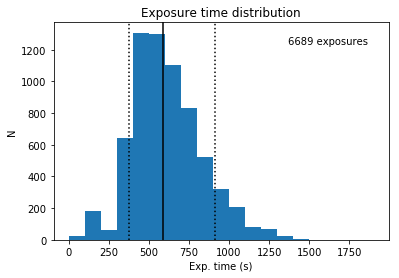

In [28]:
plt.hist(exposures['exptime'],bins=np.arange(0,2000,100))
plt.text(0.7,0.9,'%d exposures'%(len(exposures)),transform=plt.gca().transAxes)
percentiles = np.percentile(exposures['exptime'],[10,50,90])
plt.axvline(percentiles[0],c='k',ls=':')
plt.axvline(percentiles[1],c='k',ls='solid')
plt.axvline(percentiles[2],c='k',ls=':')
plt.xlabel('Exp. time (s)')
plt.ylabel('N')
plt.title('Exposure time distribution');

In [29]:
plan[0:5]

tileid,ra,dec,pass,priority,hourangle,covered,available
int32,float64,float64,int16,float64,float64,int64,bool
4,335.03,19.88,0,1.09507142857,-4.13891586268,-1,True
6,333.22,14.84,0,1.13107142857,-5.14379275346,-1,True
7,332.35,12.32,0,1.14907142857,-6.75987702507,-1,True
8,319.9,6.05,0,1.19385714286,-11.1294985935,-1,True
9,330.67,7.31,0,1.18485714286,-6.882876307,-1,True


In [30]:
weather[0:5]

mjd,open,seeing,transparency
float64,bool,float32,float32
58818.7916667,True,1.81396,0.961685
58818.7951389,True,1.61929,0.951094
58818.7986111,True,1.47662,0.967999
58818.8020833,True,1.92816,0.98349
58818.8055556,True,1.52703,0.945346


# Targets

In [31]:
ls $topdir/targets/bright/0/53

standards-bright-4-53.fits*  targets-4-53.fits*
standards-dark-4-53.fits*    truth-4-53.fits*


In [32]:
targets_onepix_path = '{topdir}/targets/bright/0/53/targets-4-53.fits'.format(topdir=topdir)
targets_path        = '{topdir}/targets/bright/targets.fits'.format(topdir=topdir)

In [33]:
t_onepix = Table.read(targets_onepix_path)
print(len(t_onepix),'rows')

111256 rows


In [34]:
t_onepix[0:3]

BRICKID,BRICKNAME,BRICK_OBJID,RA,DEC,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,SHAPEEXP_R,SHAPEEXP_E1,SHAPEEXP_E2,SHAPEDEV_R,SHAPEDEV_E1,SHAPEDEV_E2,PSFDEPTH_G,PSFDEPTH_R,PSFDEPTH_Z,GALDEPTH_G,GALDEPTH_R,GALDEPTH_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,TARGETID,DESI_TARGET,BGS_TARGET,MWS_TARGET,HPXPIXEL,SUBPRIORITY,OBSCONDITIONS
int32,str8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,int64,int64,int64,int64,float64,int64
0,3460p337,0,345.95880127,33.7933959961,4.38655,11.1833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.724577,0.804916,0.884802,0.981725,0.988737,288230376374009856,1152921504606846976,65537,0,53,0.00959843053743,7
0,3469p340,0,347.010406494,34.1110343933,19.19,25.5279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.77606,0.843008,0.908178,0.985591,0.991126,288230376374009857,1152921504606846976,131074,0,53,0.969758559448,4
0,3484p340,0,348.460510254,34.0122909546,10.9261,16.2791,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.829251,0.881507,0.931341,0.989338,0.993439,288230376374009858,1152921504606846976,131074,0,53,0.984668125654,4


## Confusion of BGS and MWS targets

In [35]:
odd = np.where(t_onepix['BGS_TARGET'] & t_onepix['MWS_TARGET'])

In [110]:
print(np.unique(t_onepix[odd]['BGS_TARGET']))
print(np.unique(t_onepix[odd]['MWS_TARGET']))
print(np.unique(t_onepix[odd]['DESI_TARGET']))
print(np.unique(t_onepix[odd]['OBSCONDITIONS']))

BGS_TARGET
----------
     65537
MWS_TARGET
----------
     65536
    DESI_TARGET    
-------------------
3458764513820540928
OBSCONDITIONS
-------------
            7
15.8461


In [112]:
print(np.max(t_onepix[odd]['FLUX_R']))

15.8461


In [48]:
t_onepix['TARGETID'][odd].min(), t_onepix['TARGETID'][odd].max()

(288230376374033789, 288230376374120679)

In [37]:
bgs_mask.names(65537)

['BGS_FAINT', 'BGS_FAINT_SOUTH']

In [38]:
mws_mask.names(65536)

['MWS_MAIN_VERY_FAINT']

In [41]:
desi_mask.names(3458764513820540928)

['BGS_ANY', 'MWS_ANY']

In [52]:
import desitarget
import desitarget.mock.io
desitarget.mock.io.decode_rownum_filenum(np.array([288230376374009856]))

(array([222298112], dtype=uint64), array([0], dtype=uint64))

In [60]:
!cat $topdir/targets/bright/select-mock-targets-bright.yaml

dust_dir: /project/projectdirs/desi/software/edison/dust/v0_1/maps
decals_brick_info: /project/projectdirs/desi/target/catalogs/brick-info-dr3.v0.0.1.fits
sources:
    BGS: {
        target_name: BGS,
        mock_dir_name: /project/projectdirs/desi/mocks/bgs/MXXL/desi_footprint/v0.0.4/BGS.hdf5,
        format: durham_mxxl_hdf5,
        magcut: 20.3,
        contam: {
            STAR: 50,
        }
    }
    FAINTSTAR: {
        target_name: FAINTSTAR,
        mock_dir_name: /project/projectdirs/desi/mocks/mws/galaxia/alpha/0.0.4_superfaint,
        format: galaxia,
        magcut: 23.5,
    }
    MWS_MAIN: {
        target_name: MWS_MAIN,
        mock_dir_name: /project/projectdirs/desi/mocks/mws/galaxia/alpha/v0.0.4,
        format: galaxia,
    }
    MWS_NEARBY: {
        target_name: MWS_NEARBY,
        mock_dir_name: /project/projectdirs/desi/mocks/mws/100pc/v0.0.3/mock_100pc.fits,
        format: 100pc,
    }
    MWS_WD: {
        target_name: MWS_WD,
        mock_dir_name: /pro

In [109]:
desitarget.obsconditions.names(7)

['DARK', 'GRAY', 'BRIGHT']